In [1]:
%matplotlib inline

#import math tools
import numpy as np

#import miscellaneous tools
from itertools import permutations, repeat
import pprint as pp

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools
import pandas as pd
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# importing tools for running QAOA
import random
from scipy.optimize import minimize, fmin, Bounds
from sympy.combinatorics.graycode import GrayCode

In [2]:
from qiskit import IBMQ
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [2]:
# Problem variables

num_weeks = 1
num_days = 1 #5
num_periods = 4
num_timeslots = num_days*num_periods

# Each subject has only one teacher
# Each teacher teaches only one subject
num_subjects = 3
num_teachers = num_subjects #21


num_students = 2 #11
num_rooms = 3

# Number of features in a room
# Ex.: has computers, has >40 chairs...
num_features = 2

In [3]:
teachers_list = [teacher for teacher in range(num_teachers)]

students_list = [student for student in range(num_students)]

In [4]:
#     r0 r1 r2
# f0 [ 0  1  1 ]
# f1 [ 1  0  0 ]
#roomFeatures = np.matrix([[0 for feature in range(num_rooms)] for event in range(num_features)])
roomFeatures = np.matrix([[0, 1, 1],
                          [1, 0, 0]])


#     f0 f1
# s0 [ 1  0 ]
# s1 [ 1  0 ]
# s2 [ 0  1 ]
# s3 [ 1  0 ]
#subjectFeatures = np.matrix([[0 for feature in range(num_features)] for event in range(num_subjects)])
subjectFeatures = np.matrix([[1, 0],
                             [1, 0],
                             [0, 1]])


#     r0 r1 r2
# s0 [ 0  1  1 ]
# s1 [ 0  1  1 ]
# s2 [ 1  0  0 ]
# s3 [ 0  1  1 ]
suitableRoom = subjectFeatures*roomFeatures
print(suitableRoom)

[[0 1 1]
 [0 1 1]
 [1 0 0]]


In [5]:
# Allocate rooms
# Each subject will be allocated to the least busy room
allocations = []
num_allocations = [0 for room in range(num_rooms)]

for subject_index, subject in enumerate(suitableRoom.tolist()):
    possible_allocations = []
    for index, room in enumerate(subject):
        if room == 1:
            possible_allocations.append(index)
    print("Subject", subject_index)
    print("Possible Allocations", possible_allocations)
    
    min_allocations = np.inf
    allocated_room = np.inf
    for alloc_index in possible_allocations:
        if num_allocations[alloc_index] < min_allocations:
            allocated_room = alloc_index
            min_allocations = num_allocations[allocated_room]
    allocations.append((subject_index, allocated_room))
    num_allocations[allocated_room] += 1

print("Number of Allocations for each Room", num_allocations)
print("Allocations", allocations)

Subject 0
Possible Allocations [1, 2]
Subject 1
Possible Allocations [1, 2]
Subject 2
Possible Allocations [0]
Number of Allocations for each Room [1, 1, 1]
Allocations [(0, 1), (1, 2), (2, 0)]


In [6]:
# Pair subjects with students
# lecture = (subject, room, student)
lectures = [(j,k,l) for j,k in allocations for l in students_list]

print(lectures)

[(0, 1, 0), (0, 1, 1), (1, 2, 0), (1, 2, 1), (2, 0, 0), (2, 0, 1)]


In [7]:
# Generate the lectureConflict Matrix
# The hard constraints of the problem are included in the matrix

#     l0 l1 l2 l3
# l0 [ 0  0  0  0 ]
# l1 [ 0  0  0  0 ]
# l2 [ 0  0  0  0 ]
# l3 [ 0  0  0  0 ]
lectureConflict = [[0 for feature in range(len(lectures))] for event in range(len(lectures))]

# If two lectures are allocated to the same room,
# share a student or have the same teacher they
# cannot be assigned to the same timeslot
for e, j in enumerate(lectures):
    subject,room,student = j
    for f,a in enumerate(lectures[e+1:]):
        subject2,room2,student2 = a
        if subject == subject2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1
        if student == student2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1
        if room == room2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1

pp.pprint(lectureConflict)

[[0, 1, 1, 0, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1],
 [1, 0, 1, 0, 0, 1],
 [0, 1, 0, 1, 1, 0]]


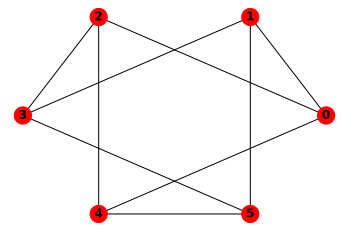

In [30]:
G = nx.Graph()
G.add_nodes_from([(num, {'color' : None}) for num in range(len(lectures))])

for e, row in enumerate(lectureConflict):
    for f, column in enumerate(row):
        if column == 1:
            G.add_edge(e,f)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

#nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)
nx.draw_circular(G, node_color=colors, node_size=300, alpha=1, ax=default_axes, font_weight='bold', with_labels=True)
plt.savefig("conflict-graph.png")

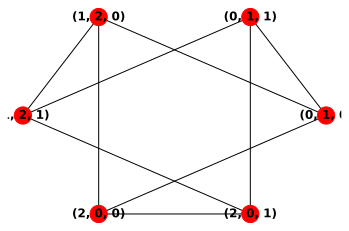

In [8]:
G_tuple = nx.Graph()
G_tuple.add_nodes_from([(tuple, {'color' : None}) for tuple in lectures])

for e, row in enumerate(lectureConflict):
    for f, column in enumerate(row):
        if column == 1:
            G_tuple.add_edge(lectures[e],lectures[f])

# Generate plot of the Graph
colors       = ['r' for node in G_tuple.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G_tuple)

nx.draw_circular(G_tuple, node_color=colors, node_size=300, alpha=1, ax=default_axes, font_weight='bold', with_labels=True)
plt.savefig("conflict-graph.pdf")

In [10]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [11]:
def color_graph_num(graph, num_color, root):
    color_index = 0
    not_allowed_color = []

    # Mark all the vertices as not visited
    visited = {x: False for x in graph.nodes}

    # Create a queue for BFS
    queue = []

    # Mark the source node as
    # visited and enqueue it
    queue.append(root)
    visited[root] = True

    while queue:
        # Dequeue a vertex from queue and color it
        source = queue.pop(0)
        not_allowed_color = [graph.nodes[neighbour]['color'] for neighbour in graph[source] 
                                if (graph.nodes[neighbour]['color'] != None 
                                    and graph.nodes[neighbour]['color'] < num_color) ]
        while color_index in not_allowed_color:
            color_index = (color_index+1)%num_color
        graph.nodes[source]['color'] = color_index
        not_allowed_color = []

        # Get all adjacent vertices of the
        # dequeued vertex s. If a adjacent
        # has not been visited, then mark it
        # visited and enqueue it
        for i in graph[source]:
            if visited[i] == False:
                queue.append(i)
                visited[i] = True

    return

In [27]:
def color_graph_coloring(graph, coloring):
    for index,node in enumerate(graph.nodes):
        graph.nodes[node]['color'] = coloring[index]
    
    return

In [13]:
# Graph Information
print("Graph information")

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nPre-coloring", coloring)

degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

#num_colors = num_timeslots
num_colors = 3
print("\nNumber of colors", num_colors)

node_list = list(G.nodes)
color_graph_num(G, num_colors, node_list[0])

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nInitial coloring", coloring)

Graph information

Pre-coloring [None, None, None, None, None, None]

Degree of each node [3, 3, 3, 3, 3, 3]

Number of colors 3

Node 0 Color 0
Neighbours Colors [1, 1, 2]

Node 1 Color 1
Neighbours Colors [0, 2, 0]

Node 2 Color 1
Neighbours Colors [0, 2, 2]

Node 3 Color 2
Neighbours Colors [1, 1, 0]

Node 4 Color 2
Neighbours Colors [0, 1, 0]

Node 5 Color 0
Neighbours Colors [1, 2, 2]

Initial coloring [0, 1, 1, 2, 2, 0]


In [14]:
class QAOAMinGraphColoring:

    def __init__(self, p, graph, num_colors):
        # Parameter p of QAOA
        # Number of times the operators are applied
        self.p = p
        
        # Inital number of colors, usually graph's degree+2
        self.num_colors = num_colors

        # The graph is a Graph object from networkx
        self.graph = graph

        # Number of vertices in the graph
        self.num_nodes = self.graph.number_of_nodes()

        # Qiskit circuit initialization
        self.circuit = QuantumCircuit((self.num_nodes*self.num_colors)+self.num_nodes,
                (self.num_nodes*self.num_colors)+self.num_nodes)

        # Variable of run results
        self.job = None
        self.results = []

    # Compute the value of the cost function
    # Count the number of USED colors
    def cost_function(self, x, G, num_colors):
        C = 0
        for color in range(num_colors):
            color_used = 0
            for node in G.nodes():
                if x[node*num_colors + color] == 1:
                    color_used = 1
                    break
            C += color_used
            
        return C

    # Create the complete QAOA circuit
    # using parameters gamma and beta
    def create_circuit(self, gamma, beta0, beta):
        # Initial state preparation
        self.initial_state()

        # Alternate application of operators
        self.mixer(beta0) # Mixer 0
        for step in range(self.p):
            self.phase_separator(gamma[step])
            self.mixer(beta[step])

        # Measurement
        self.measurement()

    # Run QAOA circuit in Qiskit
    def run(self,
            backend = Aer.get_backend('qasm_simulator'),
            backend_options = {"method" : "statevector_gpu"},
            shots = 1000,
            optimization_level = 2):
        # Execute the circuit on the selected backend
        optimized = transpile(self.circuit, backend=backend, seed_transpiler=11, optimization_level=optimization_level)

        self.job = execute(optimized, backend, shots=shots, backend_options=backend_options)
        # Grab results from the job
        result = self.job.result()
        counts = result.get_counts()

        for sample in list(counts.keys()):
            sample_coloring = []
            list_qubits = sample[::-1]

            # Restoring coloring from qubit values
            for i in range(len(self.graph)):
                for pos, char in enumerate(list_qubits[i*self.num_colors:(i*self.num_colors+self.num_colors)]):
                    if int(char):
                        # node color == pos
                        sample_coloring.append(pos)

            # use sampled bit string x to compute C(x)
            x         = [int(num) for num in list_qubits]
            tmp_eng   = self.cost_function(x,self.graph,self.num_colors)
            
            self.results.append((counts[sample], list_qubits, sample_coloring, tmp_eng))
        
        self.results.sort(reverse=True)

    # Return how long lasted the last run 
    def time(self):
        if self.job == None:
            self.run()
        # Grab results from the job
        result = self.job.result()
        print("Time taken: {} sec".format(result.time_taken))
    
    # Pretty Print all results obtained in the last run
    def show_results(self):
        if self.job == None:
            self.run()
        print("Counts, Bit Values, Coloring, C(x)")
        pp.pprint(self.results)

    def number_of_gates(self,
                        backend = Aer.get_backend('qasm_simulator')):
        qc = self.circuit
        soma  = 0
        soma0 = 0
        soma1 = 0
        soma2 = 0
        soma3 = 0

        print('Original Circuit')
        print('gates = ', qc.count_ops())
        for i in qc.count_ops():
            soma += qc.count_ops()[i]
        print('total gates = ', soma)
        print('depth = ', qc.depth())

        print('\nOptmization 0')
        optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
        print('gates = ', optimized_0.count_ops())
        for i in optimized_0.count_ops():
            soma0 += optimized_0.count_ops()[i]
        print('total gates = ', soma0)
        print('depth = ', optimized_0.depth())

        print('\nOptmization 1')
        optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
        print('gates = ', optimized_1.count_ops())
        for i in optimized_1.count_ops():
            soma1 += optimized_1.count_ops()[i]
        print('total gates = ', soma1)
        print('depth = ', optimized_1.depth())

        print('\nOptmization 2')
        optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
        print('gates = ', optimized_2.count_ops())
        for i in optimized_2.count_ops():
            soma2 += optimized_2.count_ops()[i]
        print('total gates = ', soma2)
        print('depth = ', optimized_2.depth())

        print('\nOptmization 3')
        optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
        print('gates = ', optimized_3.count_ops())
        for i in optimized_3.count_ops():
            soma3 += optimized_3.count_ops()[i]
        print('total gates = ', soma3)
        print('depth = ', optimized_3.depth())

    # Controlled Rz rotation for phase_separation and toffoli
    # The target qubit will always be the last one of the qubits
    # in the vector 'qubits'
    def cRz(self, qubits, gamma):
        num_qubits = len(qubits)
        qubits_t = qubits[1:]
        exp = np.power(2, num_qubits-1)
        a = GrayCode(num_qubits)
        gray_list = list(a.generate_gray())[1:]

        # Add the necessary gates following the Gray Code
        self.circuit.u1(gamma/exp, qubits[0])
        self.circuit.cx(qubits[0], qubits[1])
        counter = 1
        for i, node in enumerate(qubits_t):
            for j in range(np.power(2, i+1)-1):
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                codes = zip(gray_list[counter-1][::-1], gray_list[counter][::-1])
                enumerator = 0
                for u,v in codes:
                    if u != v:
                        self.circuit.cx(qubits[enumerator], node)
                    enumerator += 1
            if i < len(qubits_t)-1:
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                self.circuit.cx(node, qubits_t[i+1])
        self.circuit.u1(np.power(-1, counter)*gamma/exp, qubits_t[-1])

    # N-qubit controlled Toffoli gate
    # implemented using the cRz gate and changing
    # the base of the target qubit using Hadamard
    def toffoli(self, controls, target):
        all_qubits = controls+[target]
        self.circuit.h(target)
        self.cRz(all_qubits, np.pi)
        self.circuit.h(target)

    def find_sequence(self, pos_b, start):
        sequence = []
        end = pos_b[start]
        while end != start:
            sequence.append(end)
            end = pos_b[end]

        sequence.append(start)
        return sequence

    # Rearrange the qubit order so that qubits
    # representing the same color stay adjacent to each other
    def qubits2color(self):
        qdit_ord = []
        color_ord = []
        for i in range(self.num_nodes):
            for j in range(self.num_colors):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                qdit_ord.append(pos_a)
                color_ord.append(pos_b)

        not_visited = set(qdit_ord)

        while not_visited:
            index = next(iter(not_visited))
            sequence = self.find_sequence(color_ord, index)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop()
                while sequence:
                    qubit_b = sequence.pop()
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b
    
    # Rearrange the qubit order so that qubits
    # representing the colors of the same node stay adjacent to each other
    def color2qubits(self):
        qdit_ord = []
        color_ord = []
        for i in range(self.num_nodes):
            for j in range(self.num_colors):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                qdit_ord.append(pos_a)
                color_ord.append(pos_b)

        not_visited = set(qdit_ord)

        while not_visited:
            index = next(iter(not_visited))
            sequence = self.find_sequence(color_ord, index)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop(0)
                while sequence:
                    qubit_b = sequence.pop(0)
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b


    # Prepare the initial state of QAOA
    # Add a X gate to color the vertices following the one-hot notation
    def initial_state(self):
        coloring = [self.graph.nodes[node]['color'] for node in self.graph.nodes]
        for i, color in enumerate(coloring):
            self.circuit.x((i*self.num_colors)+color)
        return
    
    # First rearrange the order of the qubits so every color is adjacent to each other
    # Uses a controlled-Rz operation with a negative control to count the number of used colors
    # Order the qubits again so the qudits are in the right place
    def phase_separator(self, gamma):
        self.qubits2color()
        #self.circuit.barrier()
        for node in range(self.num_colors*self.num_nodes):
           self.circuit.x(node)
        for k in range(self.num_colors):
            qubits = [k*self.num_nodes+node for node in range(self.num_nodes)]
            self.cRz(qubits, 2*gamma)
        for node in range(self.num_colors*self.num_nodes):
            self.circuit.x(node)
        #self.circuit.barrier()
        self.color2qubits()
        #self.circuit.barrier()


    # Apply a controlled XX-YY rotation in the qubits representig the colors
    # i and j if none of the nodes in the neighbourhood are colored either i or j
    def partial_mixer(self, neighbour, ancilla, target, beta):
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

        # Phase correction
        self.circuit.u1(-beta, ancilla)

        # Controlled Rxx
        self.circuit.h(target[0])
        self.circuit.h(target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], 2*beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.h(target[0])
        self.circuit.h(target[1])

        # Controlled Ryy
        self.circuit.rx(-np.pi/2,target[0])
        self.circuit.rx(-np.pi/2,target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], 2*beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.rx(np.pi/2,target[0])
        self.circuit.rx(np.pi/2,target[1])

        #self.circuit.barrier()
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

    def neighbourhood(self, node, color):
        neighbour = self.graph[node]
        neighbour_qubit = [color+(self.num_colors*u) for u in neighbour]

        return neighbour_qubit

    # Apply the partial mixer for each pair of colors of each node
    def mixer(self, beta):
        for u in range(self.num_nodes):
            for i in range(self.num_colors):
                neighbours_i = self.neighbourhood(u, i)
                for j in range(self.num_colors):
                    if i < j:
                        neighbours_j = self.neighbourhood(u, j)
                        neighbours = neighbours_i+neighbours_j
                        self.partial_mixer(neighbours,
                                self.num_nodes*self.num_colors+u,
                                [i+(self.num_colors*u), j+(self.num_colors*u)],
                                beta)

    # Apply the measurement operation for every qubit
    def measurement(self):
        qubits = [num for num in range(self.num_nodes*self.num_colors+self.num_nodes)]
        self.circuit.measure(qubits, qubits)
        return

In [32]:
# Compute the value of the cost function
# Minimize the number of USED colors
def cost_function_timetable(x, G, num_colors, list_students):

    coloring = []

    for i in range(len(G)):
        for pos, char in enumerate(x[i*num_colors:(i*num_colors+num_colors)]):
            if int(char):
                coloring.append(pos)

    color_graph_coloring(G, coloring)

    C = 0
    lectures = G.nodes
    for student in list_students:
        lecture_student = [(j,k,l) for (j,k,l) in lectures if l == student]
        timeslots = [G.nodes[key]['color'] for key in list(lecture_student)]
        timeslots.sort()
        new_timeslots = [x%num_colors for x in timeslots]

        # Students shouldn't have lectures at the last time of the day
        for time in new_timeslots:
            if time % num_colors == num_colors-1:
                C += 1

        day = []
        last_lecture = -np.inf
        for time in new_timeslots:
            if last_lecture >= time:
                # Students shouldn't have only one lecture in a day
                if len(day) == 1:
                    C += 1
                #Students shouldn't have many consecutive lectures
                else:
                    for index, lect in enumerate(day):
                        if index+1 < len(day) and day[index+1] == lect+1:
                            C += 1
                day = []

            last_lecture = time
            day.append(last_lecture)
        for index, lect in enumerate(day):
            if index+1 < len(day) and day[index+1] == lect+1:
                C += 1

    return C

In [16]:
p = 1
gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
beta0 =  random.uniform(0, np.pi)
beta  = [random.uniform(0, np.pi) for _ in range(p)]

QAOA_circ = QAOAMinGraphColoring(p, G, num_colors)
print("QAOA Initialized.\n")

QAOA_circ.create_circuit(gamma, beta0, beta)
print("Circuit Created.\n")

QAOA Initialized.

Circuit Created.



In [17]:
# Execute the circuit
QAOA_circ.run()
print("Circuit Run.\n")

Circuit Run.



In [34]:
# Grab results from the job
results = QAOA_circ.results
shots = 1000
avr_C       = 0
for sample in results:
    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in sample[1]]
    tmp_eng   = cost_function_timetable(x,G_tuple,num_colors, students_list)

    # compute the expectation value and energy distribution
    avr_C     = avr_C    + sample[0]*tmp_eng

# Calculating f(x) by taking the average of the probability distribution
Mp_sampled   = avr_C/shots
print(Mp_sampled)

6.0


In [ ]:
QAOA_circ.time()

In [ ]:
QAOA_circ.show_results()

In [ ]:
# Evaluate the data from the simulator
counts = result.get_counts()

avr_C       = 0
min_C       = [0, G.number_of_nodes()]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

sample_list = []
for sample in list(counts.keys()):

    sample_coloring = []
    list_qubits = sample[::-1]

    for i in range(len(G)):
        for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
            if int(char):
                # color = pos
                sample_coloring.append(pos)

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G_tuple,num_colors, students_list)
    
    sample_list.append((counts[sample], sample_coloring, tmp_eng))

    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
        
    # save best bit string
    if( min_C[1] > tmp_eng):
        min_C[0] = sample
        min_C[1] = tmp_eng
                    
M1_sampled   = avr_C/shots

In [ ]:
print('\n --- EXTRA RESULTS ---\n')

max_counts = max(counts, key=lambda key: counts[key])
maximum_coloring = []
list_qubits = max_counts[::-1]

for i in range(len(G)):
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            maximum_coloring.append(pos)

print("\nMax Coloring", maximum_coloring)
print("\nMax Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

max_num = [int(num) for num in list(max_counts)]
max_fun   = cost_function_C(max_num, G_tuple, num_colors, students_list)
print('\nThe approximate solution of max_counts = %s with C(x*) = %d' % (max_counts,max_fun))
print('The number of times this solution showed was: %d' %(counts[max_counts]))


print('\n --- SIMULATION RESULTS ---\n')
#print("Initial Coloring", coloring)

final_coloring = []
list_qubits = min_C[0][::-1]
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            final_coloring.append(pos)

print("\nFinal Coloring",final_coloring)
print("\nFinal Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

print('\nThe approximate solution is x* = %s with C(x*) = %d' % (min_C[0],min_C[1]))
print('The number of times this solution showed was: %d \n' %(counts[min_C[0]]))

print('The sampled mean value is Mp_sampled = %.02f' % (M1_sampled))

print('The cost function is distributed as: \n') 
show_figure(plot_histogram(hist,figsize = (8,6),bar_labels = False))

In [ ]:
# Graph Information
print("New Graph information")
degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

num_colors = num_timeslots
print("\nNumber of colors", num_colors)

color_graph_coloring(G, final_coloring)

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

print("\nFinal coloring", final_coloring)

In [ ]:
# QAOA parameters
beta0 = random.uniform(0, np.pi)
gamma = random.uniform(0, 2*np.pi)

# Graph
num_colors = 4
num_nodes = G.number_of_nodes()

node_list = list(G.nodes)
color_graph_num(G, num_colors, node_list[0])
coloring = [G.nodes[node]['color'] for node in G.nodes]

circuit = QAOAMinGraphColoring(G, num_colors)

#circuit.qubits2color()
#circuit.initial_state(coloring)

def neighbourhood(node, color, graph):
        neighbour = graph[node]
        neighbour_qubit = [color+(num_colors*u) for u in neighbour]

        return neighbour_qubit

u = 0
i = 0
j = 1
neighbours_i = neighbourhood(u, i, G)
neighbours_j = neighbourhood(u, j, G)
neighbours = neighbours_i+neighbours_j
#circuit.partial_mixer(neighbours,
#                      num_nodes*num_colors,
#                      [i+(num_colors*u), j+(num_colors*u)],
#                      beta0)
#circuit.phase_separator(gamma)
#circuit.measurement()

show_figure(circuit.circuit.draw())

In [ ]:
def qaoa(par, p, G, students_list):
    # QAOA parameters
    beta0, par= par[0], par[1:]
    middle = int(len(par)/2)
    gamma = par[:middle]
    beta = par[middle:]

    # Graph
    degree = [deg for (node, deg) in G.degree()]
    num_colors = 3

    node_list = list(G.nodes)
    color_graph_num(G, num_colors, node_list[0])

    qaoa_circ = QAOAMinGraphColoring(p, G, num_colors)

    qaoa_circ.create_circuit(gamma, beta0, beta)

    backend = Aer.get_backend('qasm_simulator')
    backend_options = {"method" : "statevector_gpu"}
    shots = 1000
    optimization_level = 2

    qaoa_circ.run()

    # Grab results from the job
    results = qaoa_circ.results

    avr_C       = 0
    for sample in results:
        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in sample[1]]
        tmp_eng   = cost_function_timetable(x,G,num_colors, students_list)

        # compute the expectation value and energy distribution
        avr_C     = avr_C    + sample[0]*tmp_eng

    # Calculating f(x) by taking the average of the probability distribution
    Mp_sampled   = avr_C/shots

    return Mp_sampled

In [ ]:
p = 1
Mp1_sampled = []
archive_name = "results/p1.csv"
for iteration in range(2):
    gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
    beta0 =  [random.uniform(0, np.pi)]
    beta  = [random.uniform(0, np.pi) for _ in range(p)]
    qaoa_par = beta0+gamma+beta
    #qaoa_args = p, G, students_list
    print("Minimizing function")
    qaoa(qaoa_par, p, G, students_list)
    #res = minimize(qaoa, qaoa_par, args=qaoa_args, method='Nelder-Mead',
    #        options={'maxiter': 1, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
    #Mp1_sampled.append([res['fun'], p])
    #save_csv(Mp1_sampled, archive_name)
print(Mp1_sampled)